In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import geopandas as gpd

In [19]:
path = '../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016'

In [20]:
ds = xr.open_dataset(path + '.nc', engine = "netcdf4")

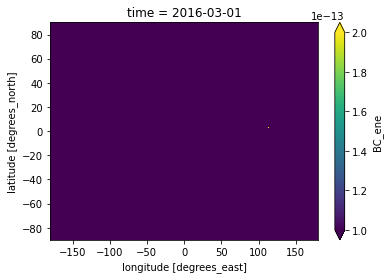

In [13]:
(xr.open_dataset('../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016_Malaysia_2x.nc')['BC_ene'].isel(time = 2)-
 xr.open_dataset('../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016.nc', engine = "netcdf4")['BC_ene'].isel(time = 2)).plot(vmin = 1e-13, vmax = 2e-13)

In [21]:
sectors_pulsed = ['BC_agr',
 'BC_ene',
 'BC_ind',
 'BC_rco',
 'BC_slv',
 'BC_tra',
 'BC_wst'
]
#pulsing all but shipping since that is offshore and we're doing land based emissions right now. when you do ocean locations you can pulse only shipping

In [22]:
doubled = False
high_pulse = True
addition = False

if doubled and high_pulse == True:
    print('ERROR: select only one option')
if doubled and addition == True:
    print('ERROR: select only one option')
if addition and high_pulse == True:
    print('ERROR: select only one option')

In [23]:
if high_pulse == True:
    increase_amt = 15
if doubled == True:
    increase_amt = 1
if addition == True:
    increase_amt = 1e-12
#per grid box #kg/m2/s (15 if doing pulse (total of 16x), change to 1 if doing a 2x check simulation (total of 2x), 1e-12 if doing added simulation)

## Options
We have multiple options for the type of pulse, but have determined that it doesn't make a very large difference in the outcome, so are using a weighted added pulse. This weights the pulse by the existing emissions fields. We use a 2x pulse for checks, a 15x pulse to create the functions, and a 1e-12 addition. 

# Addition

## Regional

In [7]:
if addition == True:
    ### create a pulsed dataset
    pulse_ds =  ds.drop(['BC_ind',
                         'BC_rco',
                         'BC_slv',
                         'BC_tra',
                         'BC_wst',
                         'BC_shp', 
                         'BC_agr']).copy()
    pulse_ds = pulse_ds.fillna(0)#.round(12)
    pulse_ds += increase_amt

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']


In [ ]:
if addition == True:

    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output since that is our focus
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_plus_{increase_amt}.nc')

## Country Multiplication

In [17]:
if addition == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")

In [10]:
if addition == True:

    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + r + f'_plus_{increase_amt}.nc')



# Weighted Multiplication

## Regional

In [25]:
if doubled or high_pulse == True:
    ### create a pulsed dataset
   # # pulse_ds =  ds.drop(['BC_ind',
   #                       'BC_rco',
   #                       'BC_slv',
   #                       'BC_tra',
   #                       'BC_wst',
   #                       'BC_shp', 
   #                       'BC_agr']).copy()
    pulse_ds = ds*increase_amt


In [16]:
if doubled or high_pulse == True:

    ### import the regions we are interested in ###
    ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']
    
    
    ### Global: Modify CEDs files
    regions = regionmask.defined_regions.ar6.land
    for r in ar6_coal_location.keys(): 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == r)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            #since we add our pulse to the original, our prescribed 'increase_amt' is always 1x less than what we want as the final pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
        ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_{increase_amt+1}x.nc')

## Country Specific

In [26]:
if doubled or high_pulse == True:

    region_df = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    regions = regionmask.from_geopandas(region_df, names="NAME", abbrevs="_from_name", name="country")
    

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:53: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(r"[(\[\]).]", "")
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/regionmask/core/_geopandas.py:54: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace("[/-]", " ")


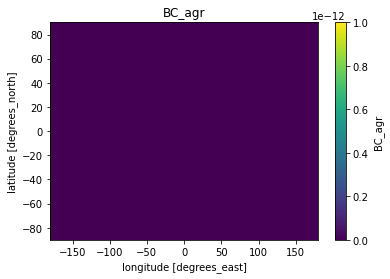

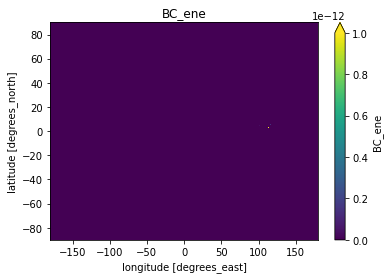

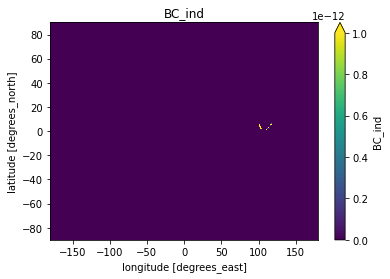

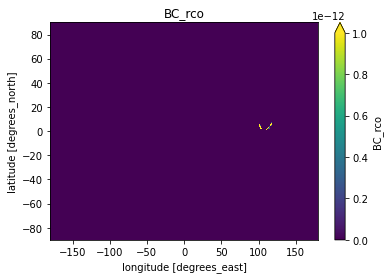

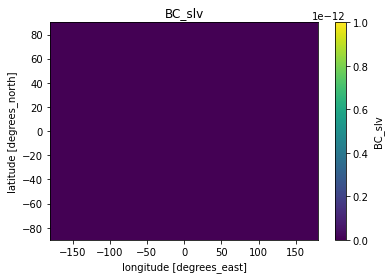

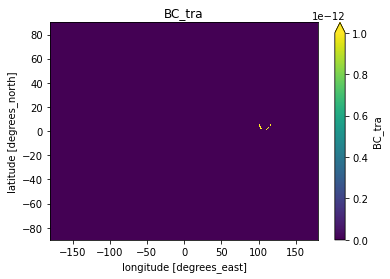

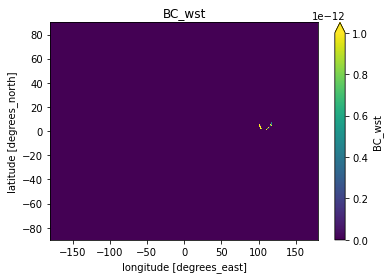

In [27]:
if doubled or high_pulse == True:
    
    for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
        ds_new = ds.copy()
        mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
        contiguous_mask = ~np.isnan(mask)& (mask == regions[r].number)
        ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
        for sector in sectors_pulsed:
            ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
            ds_new[sector].attrs = ds[sector].attrs
            fig, ax = plt.subplots()
            ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
            plt.title(sector)
       #ds_new.to_netcdf(path + '_' + r + f'_{increase_amt+1}x.nc')


## All country for linearity

In [11]:
# no phillipines (check why)
# no singapore bc no change

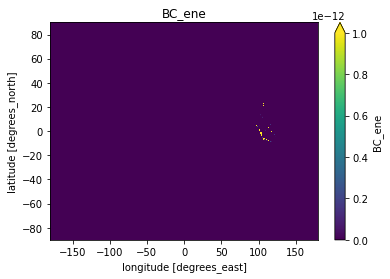

In [12]:
if doubled or high_pulse == True:
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask) & ((mask == regions['Cambodia'].number) | (mask == regions['Indonesia'].number) | (mask == regions[ 'Malaysia'].number) | (mask == regions[ 'Vietnam'].number))
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    for sector in sectors_pulsed:
        ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
        ds_new[sector].attrs = ds[sector].attrs
        fig, ax = plt.subplots()
        ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
        plt.title(sector)
    ds_new.to_netcdf(path + '_' + 'all_countries' + f'_{increase_amt+1}x.nc')



In [27]:
(ds_new-ds)['BC_ene'].min()

<xarray.DataArray 'BC_ene' ()>
array(0.)

In [22]:
ds_new

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2016-12-01
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    BC_agr   (time, lat, lon) float32 ...
    BC_ene   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    BC_ind   (time, lat, lon) float32 ...
    BC_rco   (time, lat, lon) float32 ...
    BC_shp   (time, lat, lon) float32 ...
    BC_slv   (time, lat, lon) float32 ...
    BC_tra   (time, lat, lon) float32 ...
    BC_wst   (time, lat, lon) float32 ...
Attributes: (12/37)
    CDI:                         Climate Data Interface version 1.9.4 (http:/...
    history:                     Thu Jun 24 17:01:55 2021: cdo selyear,2016 ....
    source:                      CEDS-2021-04-21: Community Emissions Data Sy...
    institution:                 Joint Global Change Research Institute, Paci...
    Conventions:                 CF-1.6
    activity_id:                 input4MIPs
    ...                          ...
    data_usage_tips:             Note that these are monthly average fluxes.
    reporting_unit:              Mass flux of BC, reported as carbon mass
    references:                  https://doi.org/10.25584/PNNLDataHub/1779095
    nco_openmp_thread_number:    1
    NCO:                         netCDF Operators version 4.7.4 (http://nco.s...
    CDO:                         Climate Data Operators version 1.9.4 (http:/...

In [48]:
## NOTE-- Singapore does not have any difference when just the energy is pulsed ##

## check the various patterns of emissions w/ other sectors

In [72]:
ds_r = {}
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 
    ds_r[r] = xr.open_dataset(path + '_' + r + f'_{increase_amt}x_{sector}.nc')

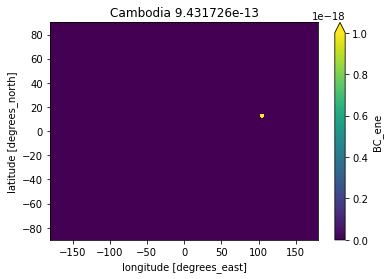

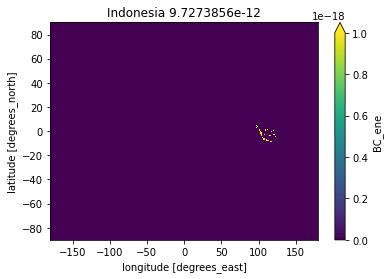

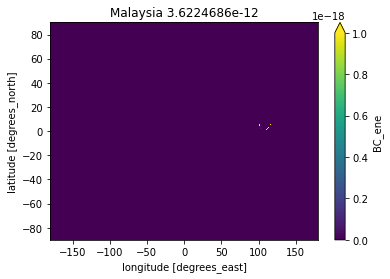

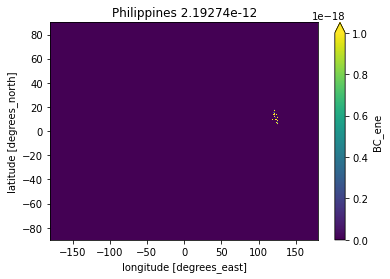

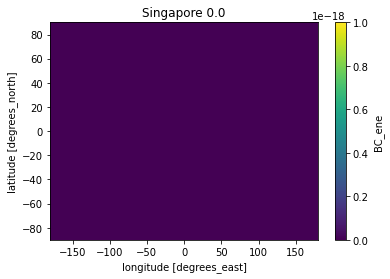

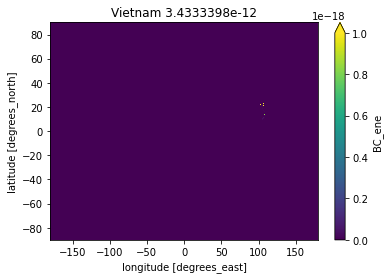

In [81]:
for r in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore','Vietnam']: 

    fig, ax = plt.subplots()
    ((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-18)
    plt.title(r + ' ' + str(((ds_r[r][sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).values.max()))

# CEDS Cosine Weighted

In [5]:
#estimated center of the US at 47 N 101 W

In [6]:
center = ds.sel(lon = -98, lat = 39, method = 'nearest')

In [7]:
lat_w = 20 #degrees (doing 2x our grid size, can change)
lon_w = 25 #degrees (doing 2x our grid size, can change)

In [8]:
A = increase_amt

In [9]:
pulse_ds = A*np.cos(np.pi/2 * (ds['lat'] - center['lat'])/lat_w)**2 * np.cos(np.pi/2 * (ds['lon'] - center['lon'])/lon_w)**2

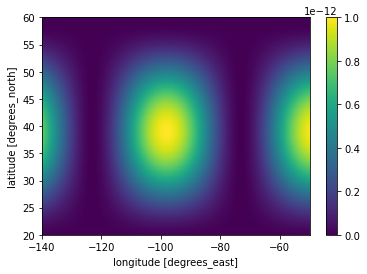

In [29]:
pulse_ds.plot()

In [10]:
us_pulse = pulse_ds.loc[dict(lat = slice(center['lat']-lat_w, center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w, center['lon']+lon_w))].rename('pulse')

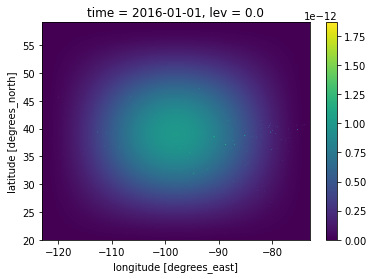

In [11]:
(ds['PEC']+pulse_ds.loc[dict(lat = slice(center['lat']-lat_w,center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w,center['lon']+lon_w))]).isel(time = 0, lev = 0).plot()

In [12]:
ds_out = xr.merge([ds['PEC'], us_pulse])

In [13]:
ds_out['pulse'] = ds_out['pulse'].fillna(0)

In [14]:
ds_out['pulse_added'] = (ds_out['PEC'] + ds_out['pulse'])

In [15]:
ds_out['pulse_added'].attrs = ds['PEC'].attrs

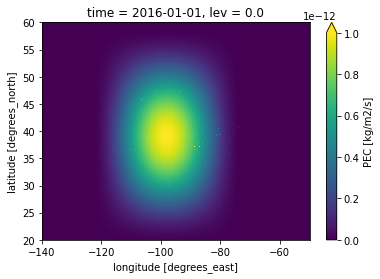

In [16]:
(ds_out['pulse_added']).isel(lev = 0).plot(vmax = 1e-12)

In [25]:
ds['PEC'] = ds_out['pulse_added'].astype('float32')

In [27]:
ds['PEC'].dtype

dtype('float32')

In [28]:
ds.to_netcdf(path + '_us_cos_pulse.nc')

# US Only, NEI Modification

01 done


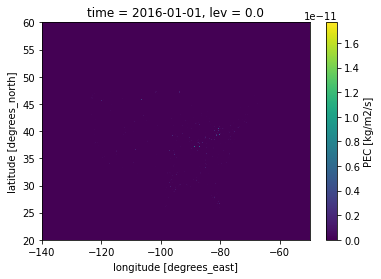

In [30]:
### US Only (modify NEI Files)
# POC for OC (in NEI)
# PEC for BC (in NEI)
poll = 'PEC'
increase_amt = 15
for m in ['01']:#,'04','07','10']:

    ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")
    ds[poll] *= increase_amt
    ds[poll].isel(time = 0, lev = 0).plot()
    #ds.to_netcdf(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}_mod_{poll}_varied.ncf')
    print(m, 'done')

In [35]:
ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")